# Using data to understand the difference of AirBnB rental markets between Seattle and Boston


## Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

## Overview
In this project, I aimed to compare the AirBnB rental markets of Seattle and Boston by using the AirBnB data from the kaggle. Mainly, I plotted the distribution of the price of two cities to see if there is any difference. In additon, I also built a model to predict the price by using the variables of interest.

## CRISP-DM process

## Q1 Are rental markets in Boston and Seattle different?
### Business Understanding
Nowadays, AirBnB rental is a growing market. We are interested in comparing the AirBnB rental markets of two different cities to see what's the role of location (city) playing in the price.
### Data Understanding
As we have prices of all homes of two cities, we can plot the distribution of prices to see the difference. 

### Data preparation

#### Read in the data

In [2]:
Boston_listing = pd.read_csv("./data/boston/listings.csv", na_values = "N/A")
Seattle_listing = pd.read_csv("./data/seattle/listings.csv", na_values = "N/A")

In [3]:
Boston_listing.shape

(3585, 95)

In [4]:
Seattle_listing.shape

(3818, 92)

In [5]:
Boston_listing["city"] = "Boston"
Seattle_listing["city"] = "Seattle"

#### Merge two datasets

In [6]:
data = pd.concat([Boston_listing, Seattle_listing], join="inner")

In [7]:
data.shape

(7403, 92)

#### Select variables of interest

In [8]:
interest_vars = ["host_location", "host_response_time", "host_response_rate", "host_acceptance_rate", 
                "host_listings_count", "property_type", "room_type", "accommodates", "bathrooms",
                "bedrooms", "beds", "bed_type", "square_feet", "price", "weekly_price", "monthly_price", 
                 "security_deposit", "cleaning_fee", "guests_included", "extra_people", "cancellation_policy",
                "review_scores_rating", "city"]

In [9]:
data_select = data[interest_vars]

#### Drop variables contained too many NA

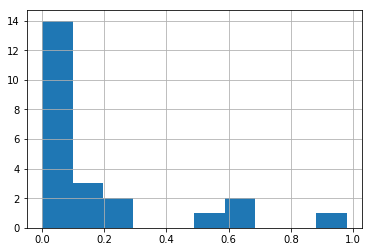

In [10]:
null_num = data_select.isnull().mean()
null_num.hist();

In [11]:
drop_list = null_num[null_num >= 0.2]

In [12]:
drop_list.index.tolist()

['square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee']

In [13]:
data_select = data_select.drop(drop_list.index, axis=1)

In [14]:
data_select.columns

Index(['host_location', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'price', 'guests_included', 'extra_people',
       'cancellation_policy', 'review_scores_rating', 'city'],
      dtype='object')

In [15]:
data_select.shape

(7403, 18)

#### Change character columns into numeric columns

In [16]:
def char_to_num(col):
    ''' Input one character price column and return a numeric column '''
    col.replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
    new_col = col.apply(pd.to_numeric)
    return new_col
    

data_select.price = char_to_num(data_select.price) / 100
data_select.extra_people = char_to_num(data_select.extra_people) / 100
data_select.host_acceptance_rate = char_to_num(data_select.host_acceptance_rate)
data_select.host_response_rate = char_to_num(data_select.host_response_rate)

#### Histogram of the price

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


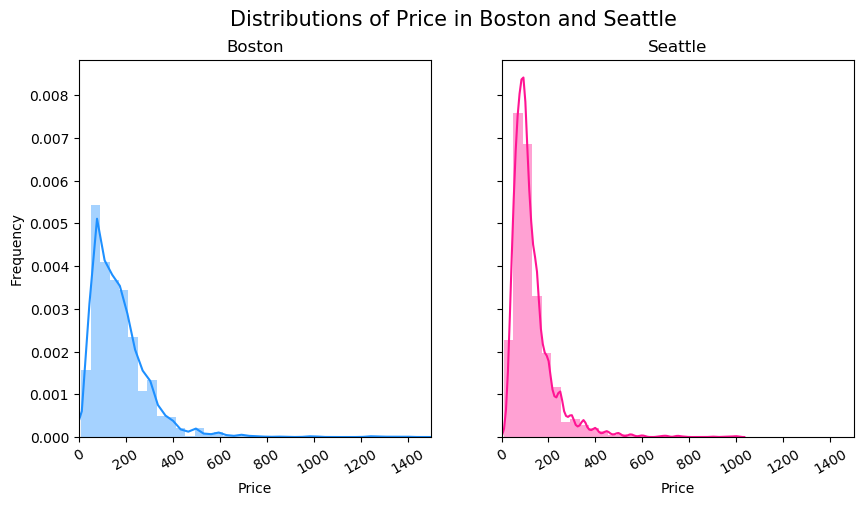

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, dpi=100)
x1 = data_select.loc[(data_select.city=='Boston', 'price')]
x2 = data_select.loc[(data_select.city=='Seattle', 'price')]
bins=np.linspace(data_select.price.min(), data_select.price.max(), 100)
sns.distplot(x1 , color="dodgerblue", ax=axes[0],bins = bins, axlabel='Boston')
axes[0].set_xlim([0, 1500]);
sns.distplot(x2 , color="deeppink", ax=axes[1],bins = bins, axlabel='Seattle')
axes[1].set_xlim([0, 1500]);
for tick in axes[0].get_xticklabels():
    tick.set_rotation(30)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(30)
fig.suptitle('Distributions of Price in Boston and Seattle', fontsize=15)
axes[0].title.set_text('Boston')
axes[1].title.set_text('Seattle')
axes[0].set_xlabel('Price')
axes[1].set_xlabel('Price')
axes[0].set_ylabel('Frequency');

#### Boxplots of the price

Text(0.5, 1.0, 'Boxplots of Price in Boston and Seattle')

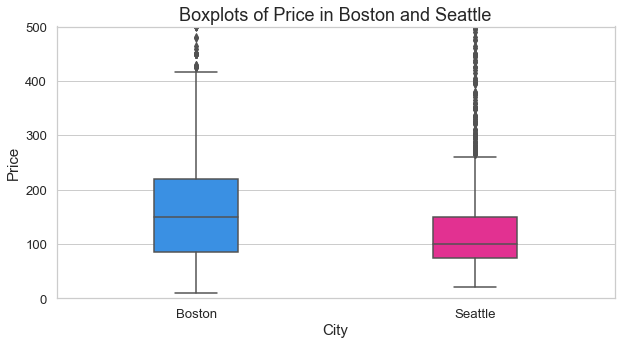

In [18]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
my_pal = {"Boston": "dodgerblue", "Seattle": "deeppink"}
fig_box = sns.boxplot(x="city", y="price", data=data_select, palette=my_pal, width=0.3)
fig_box.set_ylim([0, 500]);
fig_box.set_xlabel("City", fontsize = 15)
fig_box.set_ylabel("Price", fontsize = 15)
fig_box.set_title("Boxplots of Price in Boston and Seattle", fontsize = 18)

#### Descriptive Statistics

In [19]:
aggregation = {"price":{"N": "count",
                        "min": "min",
                        "max": "max",
                       "mean": "mean",
                       "median": "median"}
              }

table = pd.DataFrame(data_select.groupby("city").agg(aggregation)).round(2)
table

/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


price                             
            N   min     max    mean median
city                                      
Boston   3585  10.0  4000.0  173.93  150.0
Seattle  3818  20.0  1000.0  127.98  100.0

### Evaluate the Results
* The distributions of price of AirBNB in Seattle and Bostion are different. 
* Althogh they are both right-skewd which means there are some AirBNB homes much larger than the bulk of the homes (some large value greater than 300 dollars), the distribution of price in Seattle is more right-skewed.

* The mean of price of AirBNB homes in Boston is much higher than that in Seattle. Compared to Seattle, there are more homes with price higher than $200 in Boston.

## Q2 What's the difference in price between different property type in two cities? 
### Business Understanding
After comparing the distributions of prices of two cities, we had a broad picture of difference. However, we also want to know the detailed difference in price in each property in two cities.

### Data Understanding
As we have the price and property type of each home in two cities, we can make boxplots and calculate some descriptive statistics to see the difference. 
###  Prepare Data

In [20]:
aggregation = {"price":{"N": "count",
                        "min": "min",
                        "max": "max",
                       "mean": "mean",
                       "median": "median"}
              }

pd.DataFrame(data_select.groupby(["city", "property_type"]).agg(aggregation)).round(2)

price                              
                            N    min     max    mean median
city    property_type                                      
Boston  Apartment        2612   10.0  4000.0  181.97  159.0
        Bed & Breakfast    41   44.0   350.0  129.37  100.0
        Boat               12  175.0   425.0  268.83  262.5
        Camper/RV           1   60.0    60.0   60.00   60.0
        Condominium       231   30.0   700.0  190.25  160.0
        Dorm                2   50.0    75.0   62.50   62.5
        Entire Floor        4   80.0   155.0  122.00  126.5
        Guesthouse          1  289.0   289.0  289.00  289.0
        House             562   20.0  1300.0  131.60   84.5
        Loft               39   30.0   500.0  185.41  166.0
        Other              17   40.0   500.0  229.94  218.0
        Townhouse          54   44.0   700.0  149.04   99.0
        Villa               6   40.0   400.0  189.50  170.0
Seattle Apartment        1708   20.0   999.0  122.93  110.0
        Bed & Breakfast    37   30.0   299.0  112.05   99.0
        Boat                8   75.0   775.0  282.38  150.0
        Bungalow           13   65.0   349.0  115.62   95.0
        Cabin              21   52.0   300.0  104.67   95.0
        Camper/RV          13   45.0   375.0  120.46   82.0
        Chalet              2   62.0   135.0   98.50   98.5
        Condominium        91   50.0   700.0  151.11  115.0
        Dorm                2   38.0    41.0   39.50   39.5
        House            1733   25.0  1000.0  132.35   95.0
        Loft               40   25.0   425.0  135.70  102.5
        Other              22   39.0   170.0   94.68   86.5
        Tent                5   25.0    65.0   54.00   65.0
        Townhouse         118   28.0   498.0  129.46   97.0
        Treehouse           3   48.0   200.0  101.00   55.0
        Yurt                1  100.0   100.0  100.00  100.0

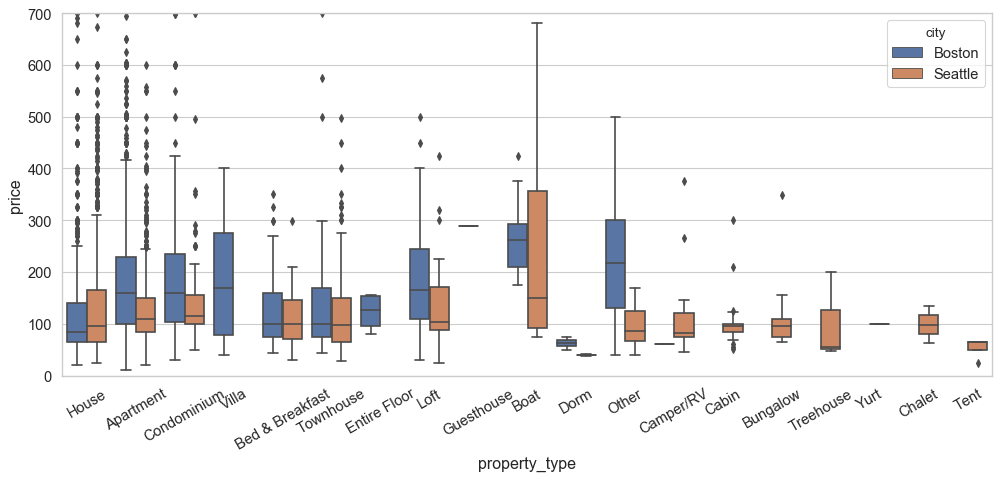

In [21]:
fig = plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
fig = sns.boxplot(x = "property_type", y = "price", hue = "city", data = data_select)
fig.set_ylim([0, 700])
for tick in fig.get_xticklabels():
    tick.set_rotation(30)

### Evaluate the Results
* Except house, prices of other types of property in Boston are tend to be higher than those in Seattle.
* Most AirBNB homes are apartments, Condominium in two cities.
* Boat is most expensive property type among all property types in Seattle. Guesthouse is most expensive property type among all property types in Boston.
* Some types of homes even don't exist in Boston.

##  Q3 Can we use selected variables to predict the price?
### Business Understanding
We also want to know what decide the price and can we use the variables we have to predict the price.

### Data Understanding
We can use the linear regression and ElasticNet to build models to predict the price.

###  Prepare Data

In [22]:
data_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 3817
Data columns (total 18 columns):
host_location           7384 non-null object
host_response_time      6409 non-null object
host_response_rate      6409 non-null float64
host_acceptance_rate    6159 non-null float64
host_listings_count     7401 non-null float64
property_type           7399 non-null object
room_type               7403 non-null object
accommodates            7403 non-null int64
bathrooms               7373 non-null float64
bedrooms                7387 non-null float64
beds                    7393 non-null float64
bed_type                7403 non-null object
price                   7403 non-null float64
guests_included         7403 non-null int64
extra_people            7403 non-null float64
cancellation_policy     7403 non-null object
review_scores_rating    5943 non-null float64
city                    7403 non-null object
dtypes: float64(9), int64(2), object(7)
memory usage: 1.2+ MB


In [23]:
## Too many locations, drop location
data_select = data_select.drop(columns="host_location")

In [24]:
from sklearn.impute import SimpleImputer
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(data_select))
imputed_DF.columns = data_select.columns
imputed_DF.index = data_select.index

In [25]:
imputed_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 3817
Data columns (total 17 columns):
host_response_time      7403 non-null object
host_response_rate      7403 non-null object
host_acceptance_rate    7403 non-null object
host_listings_count     7403 non-null object
property_type           7403 non-null object
room_type               7403 non-null object
accommodates            7403 non-null object
bathrooms               7403 non-null object
bedrooms                7403 non-null object
beds                    7403 non-null object
bed_type                7403 non-null object
price                   7403 non-null object
guests_included         7403 non-null object
extra_people            7403 non-null object
cancellation_policy     7403 non-null object
review_scores_rating    7403 non-null object
city                    7403 non-null object
dtypes: object(17)
memory usage: 1.2+ MB


In [26]:
imputed_DF.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'guests_included',
       'extra_people', 'cancellation_policy', 'review_scores_rating', 'city'],
      dtype='object')

In [27]:
## As the distribution of price is right-skewed, we use log transformation.
imputed_DF.price = np.log(imputed_DF["price"].astype(float))

In [28]:
## change categorical variables into dummy variable
cat = ["host_response_time", "property_type", "room_type", "bed_type", "cancellation_policy", "city"]
df_dummy = pd.get_dummies(imputed_DF[cat])
imputed_DF_dummy = pd.concat([imputed_DF, df_dummy], axis=1)


In [29]:
imputed_DF_dummy.drop(cat, inplace=True, axis=1)

In [30]:
final_DF = imputed_DF_dummy

In [31]:
# Split data into training and test data, and fit a linear model
from sklearn.model_selection import train_test_split
y = final_DF.price.values
X = final_DF.drop("price", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)

###  Data Modeling

In [32]:
# fit a simple linear regression
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train, y_train) 
y_predict2 = linear.predict(X_test)
r2_score(y_test, y_predict2)

0.6203475752368098

In [33]:
# fit a ElasticNet model to avoid overfitting
from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(cv=5, random_state=0, normalize=True)
regr.fit(X_train, y_train) 

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=True, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [34]:
y_predict = regr.predict(X_test)

In [35]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, y_predict)

0.6198818646968127

### Evaluate the Results
* The R squared of test dataset for multivariate linear regression is 0.62
* The R squared of test dataset for ElasticNet is 0.62 which is  approximately same as it for linear regression.
* Two models are underfitted. There are some other important variables that are not taken into consideration in this condition. We can not only use these variables of interest (city, property_type, review score and etc.) to predict the price of AirBNB homes.